In [90]:
!pip install CausalInference
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00


IMPORT

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import linearmodels as lm
from causalinference.causal import CausalModel
from google.colab import files

In [92]:
#Import Data
uploaded = files.upload()

Saving student.csv to student (1).csv


Pre Processing

In [117]:
#Read the data
df = pd.read_csv('student.csv')

In [118]:
df.head()

,StudentID,Gender,Age,StudyHoursPerWeek,AttendanceRate,GPA,Major,PartTimeJob,ExtraCurricularActivities
0,1,Male,24,37,90.75,3.47,Arts,Yes,No
1,2,Female,22,37,74.90,2.32,Education,No,No
2,3,Male,22,10,53.36,2.38,Business,No,No
3,4,Male,24,10,70.26,3.46,Science,Yes,No
4,5,Male,18,19,74.87,2.31,Education,Yes,No


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  500 non-null    int64  
 1   Gender                     500 non-null    object 
 2   Age                        500 non-null    int64  
 3   StudyHoursPerWeek          500 non-null    int64  
 4   AttendanceRate             500 non-null    float64
 5   GPA                        500 non-null    float64
 6   Major                      500 non-null    object 
 7   PartTimeJob                500 non-null    object 
 8   ExtraCurricularActivities  500 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 35.3+ KB


In [120]:
df.isnull().sum()

,0
StudentID,0
Gender,0
Age,0
StudyHoursPerWeek,0
AttendanceRate,0
GPA,0
Major,0
PartTimeJob,0
ExtraCurricularActivities,0


In [121]:
df['PartTimeJob'] = df['PartTimeJob'].map({'Yes': 1, 'No': 0})
df['ExtraCurricularActivities'] = df['ExtraCurricularActivities'].map({'Yes': 1, 'No': 0})

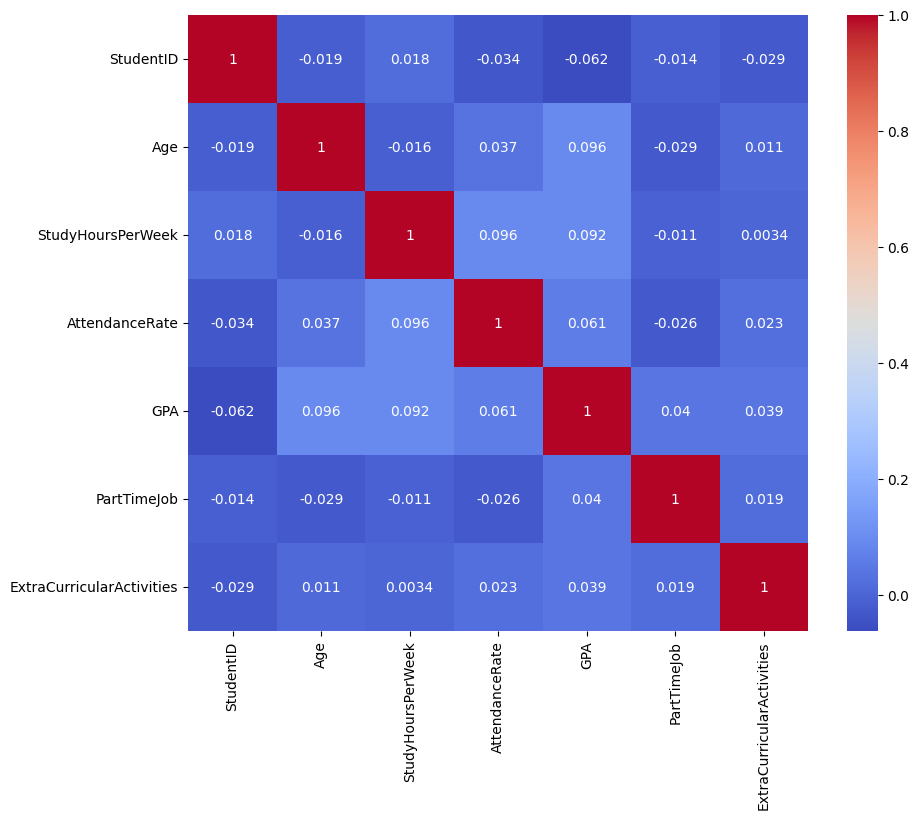

In [122]:
# Hitung matriks korelasi
corr_matrix = df.corr(numeric_only=True)

# Visualisasi heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [137]:
treated_group = df[df["PartTimeJob"]==1]
untreated_group = df[df["PartTimeJob"]==0]

treated_group["GPA"].mean() - untreated_group["GPA"].mean()

0.04565362840967646

In [124]:
def fit_standardize(data):
    data_mean = data.mean()
    data_std = data.std()
    return (data_mean, data_std)

def transform_standardize(data):
    mean, std = fit_standardize(data)
    transformed_data = (data - mean)/std
    return transformed_data

# standardization

X = ["Age", "StudyHoursPerWeek", "AttendanceRate"]
y = "GPA"

df["Age_std"] = transform_standardize(df["Age"])
df["StudyHoursPerWeek_std"] = transform_standardize(df["StudyHoursPerWeek"])
df["AttendanceRate_std"] = transform_standardize(df["AttendanceRate"])

treated_group = df[df["PartTimeJob"]==1]
untreated_group = df[df["PartTimeJob"]==0]

In [125]:
treated_group

,StudentID,Gender,Age,StudyHoursPerWeek,AttendanceRate,GPA,Major,PartTimeJob,ExtraCurricularActivities,Age_std,StudyHoursPerWeek_std,AttendanceRate_std
0,1,Male,24,37,90.75,3.47,Arts,1,0,1.521607,1.492763,1.081952
3,4,Male,24,10,70.26,3.46,Science,1,0,1.521607,-0.860928,-0.324757
4,5,Male,18,19,74.87,2.31,Education,1,0,-1.477618,-0.076364,-0.008264
5,6,Female,20,17,86.01,2.47,Business,1,0,-0.477876,-0.250712,0.756535
9,10,Female,24,1,63.32,3.96,Engineering,1,1,1.521607,-1.645491,-0.801211
...,...,...,...,...,...,...,...,...,...,...,...,...
487,488,Female,18,39,84.30,2.80,Business,1,1,-1.477618,1.667110,0.639137
489,490,Male,24,22,66.16,3.02,Education,1,0,1.521607,0.185157,-0.606236
490,491,Female,23,4,98.65,3.45,Engineering,1,1,1.021736,-1.383970,1.624314
491,492,Male,21,26,79.01,2.21,Arts,1,1,0.021994,0.533852,0.275961


In [126]:
from sklearn.neighbors import KNeighborsRegressor

In [138]:
model = KNeighborsRegressor(n_neighbors=1)

X = ["Age_std", "StudyHoursPerWeek_std", "AttendanceRate_std"]
y = ["GPA"]

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated_group[X], untreated_group[y])

In [139]:
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated_group[X], treated_group[y])

In [129]:
# find matches for the treated looking at the untreated knn model
treated_group["match"] = mt0.predict(treated_group[X])
treated_group

<ipython-input-129-ab6050377cfd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_group["match"] = mt0.predict(treated_group[X])


,StudentID,Gender,Age,StudyHoursPerWeek,AttendanceRate,GPA,Major,PartTimeJob,ExtraCurricularActivities,Age_std,StudyHoursPerWeek_std,AttendanceRate_std,match
0,1,Male,24,37,90.75,3.47,Arts,1,0,1.521607,1.492763,1.081952,2.32
3,4,Male,24,10,70.26,3.46,Science,1,0,1.521607,-0.860928,-0.324757,2.73
4,5,Male,18,19,74.87,2.31,Education,1,0,-1.477618,-0.076364,-0.008264,2.02
5,6,Female,20,17,86.01,2.47,Business,1,0,-0.477876,-0.250712,0.756535,3.16
9,10,Female,24,1,63.32,3.96,Engineering,1,1,1.521607,-1.645491,-0.801211,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,488,Female,18,39,84.30,2.80,Business,1,1,-1.477618,1.667110,0.639137,3.52
489,490,Male,24,22,66.16,3.02,Education,1,0,1.521607,0.185157,-0.606236,2.11
490,491,Female,23,4,98.65,3.45,Engineering,1,1,1.021736,-1.383970,1.624314,3.65
491,492,Male,21,26,79.01,2.21,Arts,1,1,0.021994,0.533852,0.275961,3.57


In [130]:
X = ["Age_std","StudyHoursPerWeek_std","AttendanceRate_std"]

# find matches for the untreated looking at the treated knn model
untreated_group["match"] = mt1.predict(untreated_group[X])
untreated_group

<ipython-input-130-b660d78fc07c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untreated_group["match"] = mt1.predict(untreated_group[X])


,StudentID,Gender,Age,StudyHoursPerWeek,AttendanceRate,GPA,Major,PartTimeJob,ExtraCurricularActivities,Age_std,StudyHoursPerWeek_std,AttendanceRate_std,match
1,2,Female,22,37,74.90,2.32,Education,0,0,0.521865,1.492763,-0.006205,2.85
2,3,Male,22,10,53.36,2.38,Business,0,0,0.521865,-0.860928,-1.485000,2.74
6,7,Male,19,21,55.33,3.93,Arts,0,0,-0.977747,0.097983,-1.349752,3.87
7,8,Male,18,14,57.00,2.51,Education,0,0,-1.477618,-0.512233,-1.235101,2.36
8,9,Male,19,9,63.18,3.32,Business,0,0,-0.977747,-0.948101,-0.810823,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Male,22,37,76.61,2.97,Science,0,0,0.521865,1.492763,0.111192,2.85
496,497,Male,23,11,56.29,3.20,Science,0,0,1.021736,-0.773754,-1.283845,3.56
497,498,Female,20,6,56.64,3.20,Science,0,1,-0.477876,-1.209623,-1.259816,2.13
498,499,Male,22,18,57.18,2.05,Business,0,1,0.521865,-0.163538,-1.222743,2.00


In [131]:
predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated_group.assign(match=mt0.predict(treated_group[X])),

    # find matches for the untreated looking at the treated knn model
    untreated_group.assign(match=mt1.predict(untreated_group[X]))
])

In [132]:
predicted

,StudentID,Gender,Age,StudyHoursPerWeek,AttendanceRate,GPA,Major,PartTimeJob,ExtraCurricularActivities,Age_std,StudyHoursPerWeek_std,AttendanceRate_std,match
0,1,Male,24,37,90.75,3.47,Arts,1,0,1.521607,1.492763,1.081952,2.32
3,4,Male,24,10,70.26,3.46,Science,1,0,1.521607,-0.860928,-0.324757,2.73
4,5,Male,18,19,74.87,2.31,Education,1,0,-1.477618,-0.076364,-0.008264,2.02
5,6,Female,20,17,86.01,2.47,Business,1,0,-0.477876,-0.250712,0.756535,3.16
9,10,Female,24,1,63.32,3.96,Engineering,1,1,1.521607,-1.645491,-0.801211,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Male,22,37,76.61,2.97,Science,0,0,0.521865,1.492763,0.111192,2.85
496,497,Male,23,11,56.29,3.20,Science,0,0,1.021736,-0.773754,-1.283845,3.56
497,498,Female,20,6,56.64,3.20,Science,0,1,-0.477876,-1.209623,-1.259816,2.13
498,499,Male,22,18,57.18,2.05,Business,0,1,0.521865,-0.163538,-1.222743,2.00


In [133]:
PartTimeJob = 2*predicted["PartTimeJob"] - 1
PartTimeJob

,PartTimeJob
0,1
3,1
4,1
5,1
9,1
...,...
495,-1
496,-1
497,-1
498,-1


In [134]:
y_yjm = predicted["GPA"] - predicted["match"]
y_yjm

,0
0,1.15
3,0.73
4,0.29
5,-0.69
9,1.00
...,...
495,0.12
496,-0.36
497,1.07
498,0.05


In [135]:
np.mean(PartTimeJob*y_yjm)

0.03552000000000001

In [140]:
from causalinference import CausalModel

cm = CausalModel(Y=df["GPA"].values,
                 D=df["PartTimeJob"].values,
                 X=df[["Age", "StudyHoursPerWeek", "AttendanceRate"]].values
)

cm.est_via_matching(matches=1)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.036      0.081      0.437      0.662     -0.124      0.195
           ATC      0.027      0.090      0.297      0.767     -0.150      0.204
           ATT      0.043      0.090      0.478      0.633     -0.133      0.219

